<a href="https://colab.research.google.com/github/ahmedraza1198/PROJECT/blob/main/Ahmad_Raza_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For Reading Data and handling numerical values
import warnings
warnings.filterwarnings('ignore')

#basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor
%matplotlib inline



In [ ]:
#For Exploratory data Analysis
from scipy.stats import chi2_contingency
import missingno as msno



In [ ]:
#prep
#import category_encoders as ce
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [ ]:
#models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,KFold,cross_val_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_ranInt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')
df.head()

NameError: name 'pd' is not defined

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.drop(columns=['unnamed:_0','service_history'])
df = df.rename(columns={'mileage(miles)':'mileage'})

In [ ]:
#check point
df_original = df.copy()

# 3. Data Exploration

## Overall Overview

In [ ]:
#overall overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3685 non-null   object 
 1   price              3685 non-null   int64  
 2   mileage            3685 non-null   int64  
 3   registration_year  3685 non-null   int64  
 4   previous_owners    2276 non-null   float64
 5   fuel_type          3685 non-null   object 
 6   body_type          3685 non-null   object 
 7   engine             3640 non-null   object 
 8   gearbox            3685 non-null   object 
 9   doors              3660 non-null   float64
 10  seats              3650 non-null   float64
 11  emission_class     3598 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 345.6+ KB


In [ ]:
df['fuel_type'].value_counts()

,count
fuel_type,
Petrol,2361
Diesel,1218
Petrol Hybrid,47
Electric,31
Petrol Plug-in Hybrid,27
Diesel Hybrid,1


## Duplicated Value Handling

In [ ]:
#duplicated values
print(f'duplicated values: {df.duplicated().sum()}')
#print(f'{len(df)} baris')

duplicated values: 826


In [ ]:
#drop duplicate
df = df.drop_duplicates()
print(f'duplicated values: {df.duplicated().sum()}')
print(f'tersisa {len(df)} baris')

duplicated values: 0
tersisa 2859 baris


## Missing Value Handling

In [ ]:
print(f'missing values: {df.isna().sum().sum()} \n{df.isna().sum()[df.isna().sum()>0]}')
print(f'\nmissing values: {round((df.isna().sum().sum())/len(df)*100,2)}% \n{round((df.isna().sum()[df.isna().sum()>0])/len(df)*100,2)}\n')

missing values: 1119 
previous_owners    983
engine              17
doors               25
seats               35
emission_class      59
dtype: int64

missing values: 39.14% 
previous_owners    34.38
engine              0.59
doors               0.87
seats               1.22
emission_class      2.06
dtype: float64



**drop missing value <1%**

In [ ]:
df = df.dropna(subset=['engine','doors','emission_class','seats']).reset_index(drop=True)
print(f'\nmissing values: {round((df.isna().sum().sum())/len(df)*100,2)}% \n{round((df.isna().sum()[df.isna().sum()>0])/len(df)*100,2)}\n')
print(f'tersisa {len(df)} baris')


missing values: 34.16% 
previous_owners    34.16
dtype: float64

tersisa 2793 baris


In [ ]:
#checkpoint
df.reset_index(drop=True,inplace=True)
df_hampirclean = df.copy()

In [ ]:
#restart point
df = df_hampirclean.copy()

In [ ]:

desimal = ['price','mileage']
for col in desimal:
    df[col] = df[col].astype(float)
##float to int
integral = ['doors','seats']
for col in integral:
    df[col] = df[col].astype(int)
##ordinal encoding
numerik = ['engine','emission_class']
for col in numerik:
    df[col] = df[col].replace({'Euro ':'','L':''},regex=True)
    df[col] = pd.to_numeric(df[col],errors='coerce')
##regroup
df['fuel_type'] = np.where(df['fuel_type'].str.contains('Hybrid'),'Hybrid',df['fuel_type'])
##one-hot & label encoding
oh_col = ['fuel_type','gearbox']
one_hot = pd.get_dummies(df[oh_col],drop_first=True)
df = pd.concat([df.drop(columns=oh_col), one_hot], axis=1)
df = df.replace({False:0,True:1},regex=True)
df.drop(columns='title',inplace=True)

df = df.reset_index(drop=True)
df_encoded = df.copy()

In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce

In [ ]:
#split
X = df.drop(columns='price')
y = df[['price']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)

##freq. encoding
count_encoder = ce.CountEncoder()
X_train['body_type'] = count_encoder.fit_transform(X_train['body_type'])
X_test['body_type'] = count_encoder.transform(X_test['body_type'])

#imputation
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

#merge
X_train_imputed['price'] = y_train.values
X_test_imputed['price'] = y_test.values

df_imputed = pd.concat([X_train_imputed, X_test_imputed], ignore_index=True)

In [ ]:
print(f"before: {df['previous_owners'].nunique()} unique values")
print(sorted(df['previous_owners'].unique()))
print(f"after: {df_imputed['previous_owners'].nunique()} unique values")
print(sorted(df_imputed['previous_owners'].unique()))

before: 9 unique values
[3.0, 4.0, nan, 1.0, 2.0, 5.0, 6.0, 7.0, 8.0, 9.0]
after: 29 unique values
[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 7.0, 8.0, 9.0]


it should be the same as before

In [ ]:
df_imputed['previous_owners'] = df_imputed['previous_owners'].apply(floor)
print(f"{df_imputed['previous_owners'].nunique()} unique values")
print(sorted(df_imputed['previous_owners'].unique()))

9 unique values
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
#imput to df
df = df_hampirclean.copy()
df['previous_owners'] = df_imputed['previous_owners']

In [ ]:
print(f'\nmissing values: {round((df.isna().sum().sum())/len(df)*100,2)}% \n{round((df.isna().sum()[df.isna().sum()>0])/len(df)*100,2)}\n')
print(f'tersisa {len(df)} baris')


missing values: 0.0% 
Series([], dtype: float64)

tersisa 2793 baris


In [ ]:
#checkpoints
df_clean = df.copy()

In [ ]:
df_clean

,title,price,mileage,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class
0,SKODA Fabia,6900,70189,2016,3,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6
1,Vauxhall Corsa,1495,88585,2008,4,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4
2,Hyundai i30,949,137000,2011,2,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5
3,MINI Hatch,2395,96731,2010,5,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4
4,Vauxhall Corsa,1000,85000,2013,4,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5
...,...,...,...,...,...,...,...,...,...,...,...,...
2788,Renault Megane,1395,76202,2006,4,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4
2789,Audi A4,6990,119000,2012,1,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5
2790,BMW 3 Series,3995,139000,2013,5,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5
2791,Honda Accord,1390,179190,2007,3,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4


## Feature Engineering

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2793 non-null   object 
 1   price              2793 non-null   int64  
 2   mileage            2793 non-null   int64  
 3   registration_year  2793 non-null   int64  
 4   previous_owners    2793 non-null   int64  
 5   fuel_type          2793 non-null   object 
 6   body_type          2793 non-null   object 
 7   engine             2793 non-null   object 
 8   gearbox            2793 non-null   object 
 9   doors              2793 non-null   float64
 10  seats              2793 non-null   float64
 11  emission_class     2793 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 262.0+ KB


- float: price & mileage.
- integral: doors & seats.

**dtype handling**

In [ ]:
##int to float
desimal = ['price','mileage']
for col in desimal:
    df[col] = df[col].astype(float)
    print(col,':', df[col].dtype)
##float to int
integral = ['doors','seats']
for col in integral:
    df[col] = df[col].astype(int)
    print(col,':', df[col].dtype)
##continous
numerik = ['engine']
for col in numerik:
    df[col] = df[col].replace({'L':''},regex=True)
    df[col] = pd.to_numeric(df[col],errors='coerce')
    print(col,':', df[col].dtype)

price : float64
mileage : float64
doors : int64
seats : int64
engine : float64


In [ ]:
##regroup
df['fuel_type'] = np.where(df['fuel_type'].str.contains('Hybrid'),'Hybrid',df['fuel_type'])

**extract brand & model**

In [ ]:
df['brand'] = np.where(df['title'].str.contains(r'Land Rover|Alfa Romeo|DS Automobiles'),
                       df['title'].str.split(n=2, expand=True)[0]+' '+df['title'].str.split(n=2, expand=True)[1],
                       df['title'].str.split(n=1, expand=True)[0])

df = df.rename(columns={'title': 'model'})
df['brand'].unique()

array(['SKODA', 'Vauxhall', 'Hyundai', 'MINI', 'Ford', 'Peugeot', 'BMW',
       'Citroen', 'Mercedes-Benz', 'Mazda', 'Saab', 'Volkswagen', 'Honda',
       'MG', 'Toyota', 'Volvo', 'SEAT', 'Nissan', 'Alfa Romeo', 'KIA',
       'Proton', 'Fiat', 'Renault', 'Audi', 'Mitsubishi', 'Lexus',
       'Land Rover', 'Chevrolet', 'Suzuki', 'Dacia', 'Daihatsu', 'Jeep',
       'Jaguar', 'Chrysler', 'Rover', 'DS Automobiles', 'Daewoo', 'Dodge',
       'Subaru', 'Porsche', 'Infiniti', 'Abarth', 'Smart', 'Maserati',
       'Ssangyong'], dtype=object)

## Outliers Handling

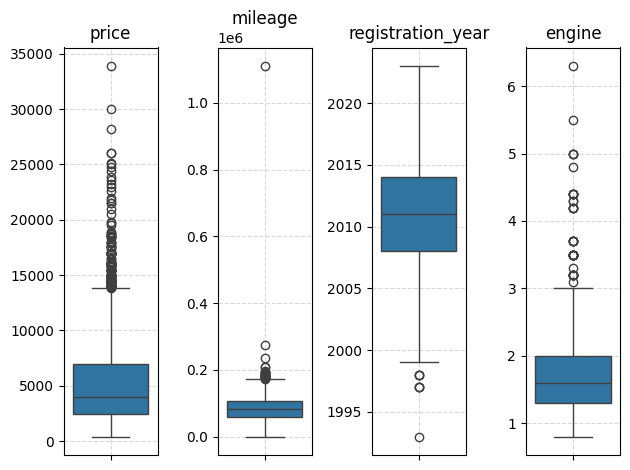

In [ ]:
kontinu = ['price','mileage','registration_year','engine']
for i in range(0,len(kontinu)):
    plt.subplot(1,4,i+1)
    sns.boxplot(y=df[kontinu[i]])
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(kontinu[i])
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
kontinu = ['price','mileage']
for i in kontinu:
    Q3 = df[i].quantile(0.75)
    Q1 = df[i].quantile(0.25)
    IQR = Q3-Q1
    bawah = Q1-1.5*IQR
    atas = Q3+1.5*IQR
    outlier = (df[i] < bawah) | (df[i] > atas)
    df = df[~outlier]

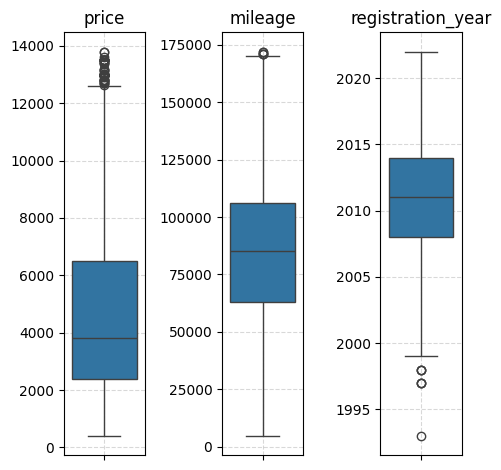

In [ ]:
kontinu = ['price','mileage','registration_year']
for i in range(0,len(kontinu)):
    plt.subplot(1,4,i+1)
    sns.boxplot(y=df[kontinu[i]])
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(kontinu[i])
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
df

,model,price,mileage,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,brand
0,SKODA Fabia,6900.0,70189.0,2016,3,Diesel,Hatchback,1.4,Manual,5,5,Euro 6,SKODA
1,Vauxhall Corsa,1495.0,88585.0,2008,4,Petrol,Hatchback,1.2,Manual,3,5,Euro 4,Vauxhall
2,Hyundai i30,949.0,137000.0,2011,2,Petrol,Hatchback,1.4,Manual,5,5,Euro 5,Hyundai
3,MINI Hatch,2395.0,96731.0,2010,5,Petrol,Hatchback,1.4,Manual,3,4,Euro 4,MINI
4,Vauxhall Corsa,1000.0,85000.0,2013,4,Diesel,Hatchback,1.3,Manual,5,5,Euro 5,Vauxhall
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,Nissan Qashqai,1695.0,104000.0,2009,3,Petrol,Hatchback,1.6,Manual,5,5,Euro 4,Nissan
2788,Renault Megane,1395.0,76202.0,2006,4,Petrol,Hatchback,1.6,Manual,5,5,Euro 4,Renault
2789,Audi A4,6990.0,119000.0,2012,1,Petrol,Saloon,2.0,Manual,4,5,Euro 5,Audi
2790,BMW 3 Series,3995.0,139000.0,2013,5,Diesel,Saloon,2.0,Manual,4,5,Euro 5,BMW


In [ ]:
#checkpoint
df_eda = df.copy()

## EDA

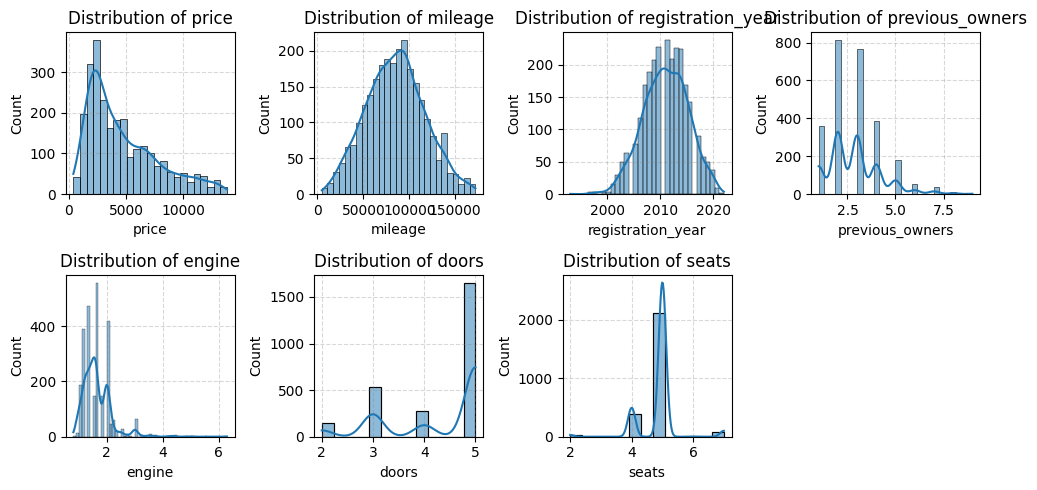

In [ ]:
plt.figure(figsize=(10,5))
for i in range(0,len(num)):
    plt.subplot(2, 4, i+1)
    sns.histplot(df[num[i]], kde=True)
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(f'Distribution of {num[i]}')

plt.tight_layout()

**Categorical Distribution**

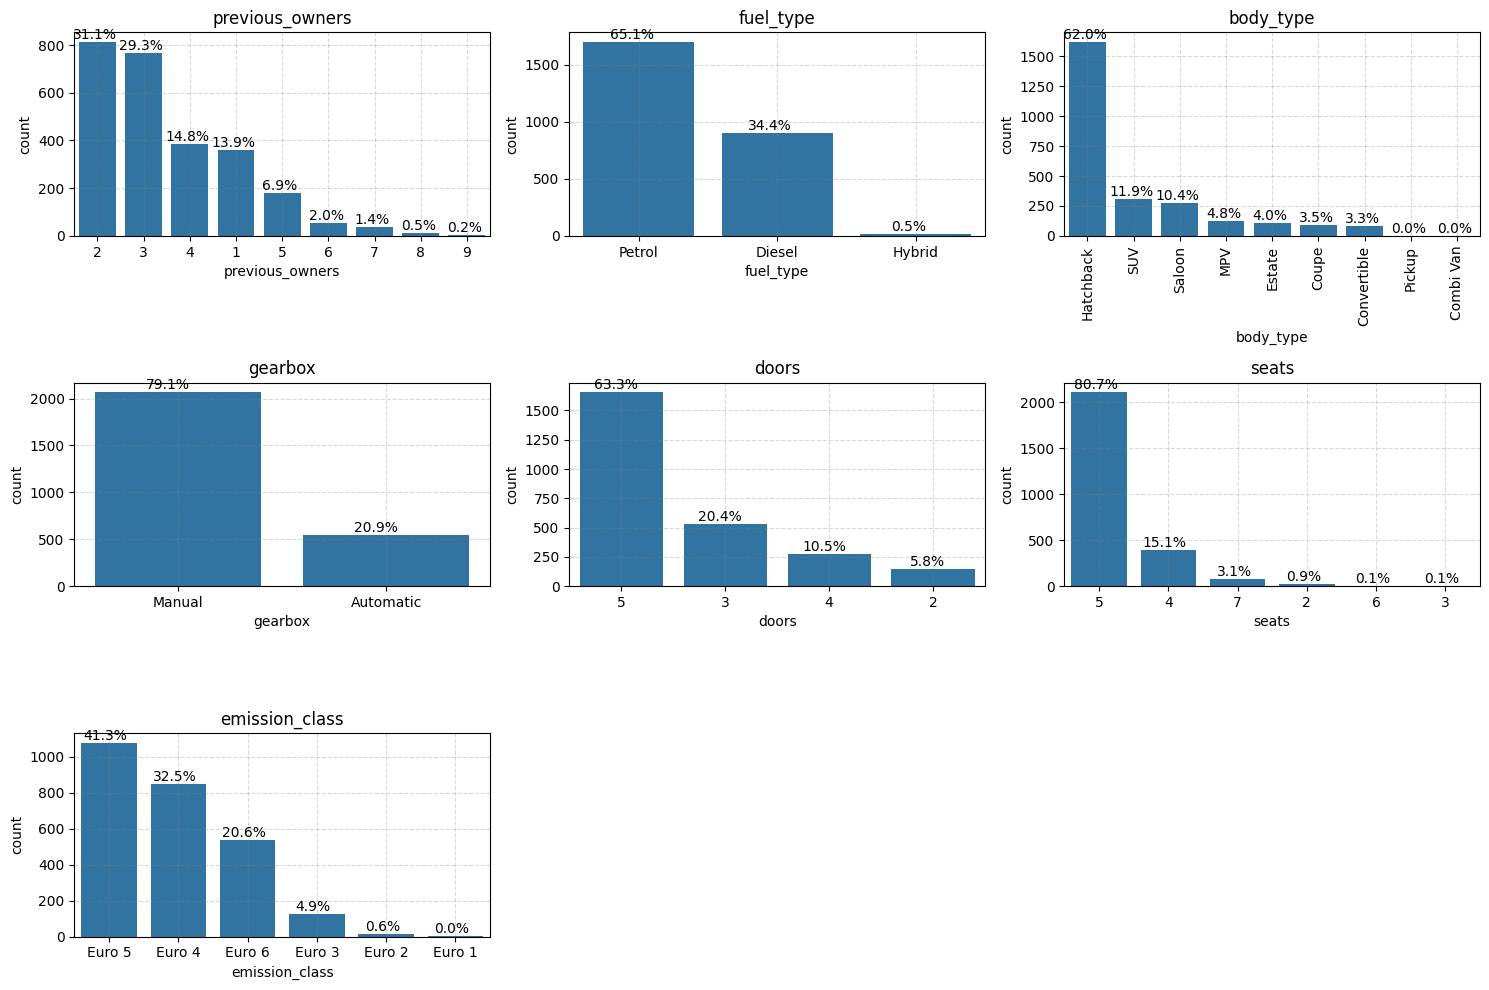

In [ ]:
features = ['previous_owners','fuel_type','body_type','gearbox','doors','seats','emission_class']
plt.figure(figsize=(15,10))
for idx,i in enumerate(features):
    urut = df[i].value_counts(ascending=False).index
    plt.subplot(3,3,idx+1)
    ax=sns.countplot(x=df[i],order=urut)
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(i)
    if i=='body_type':
        plt.xticks(rotation=90)
    total = float(len(df[i]))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

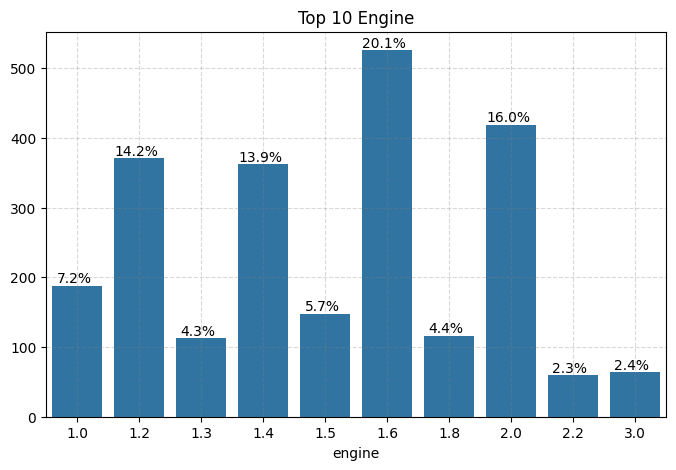

In [ ]:
top10_engine = df['engine'].value_counts().head(10)

plt.figure(figsize=(8,5))
ax=sns.barplot(x=top10_engine.index,y=top10_engine.values)
plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
plt.title('Top 10 Engine')
total = float(len(df[i]))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

### Bivariate Analysis

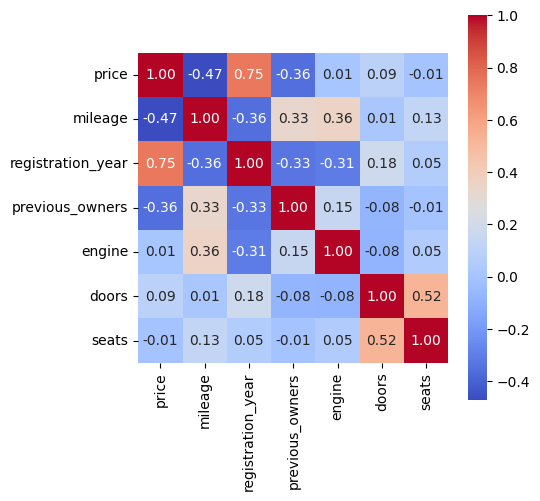

In [ ]:
df_corr = df[num].corr()

plt.figure(figsize=(5,5))
sns.heatmap(df_corr,annot=True,fmt='.2f',square=True,cmap='coolwarm')
plt.show()

**Price VS Continue Features**

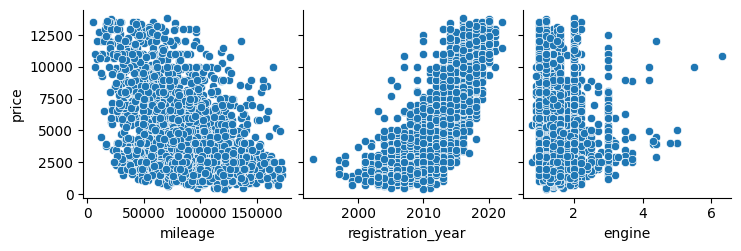

In [ ]:
features = ['mileage','registration_year','engine','price']
sns.pairplot(df[features],x_vars=features[:-1],y_vars='price')

plt.show()

**Price VS Other Numeric Features**

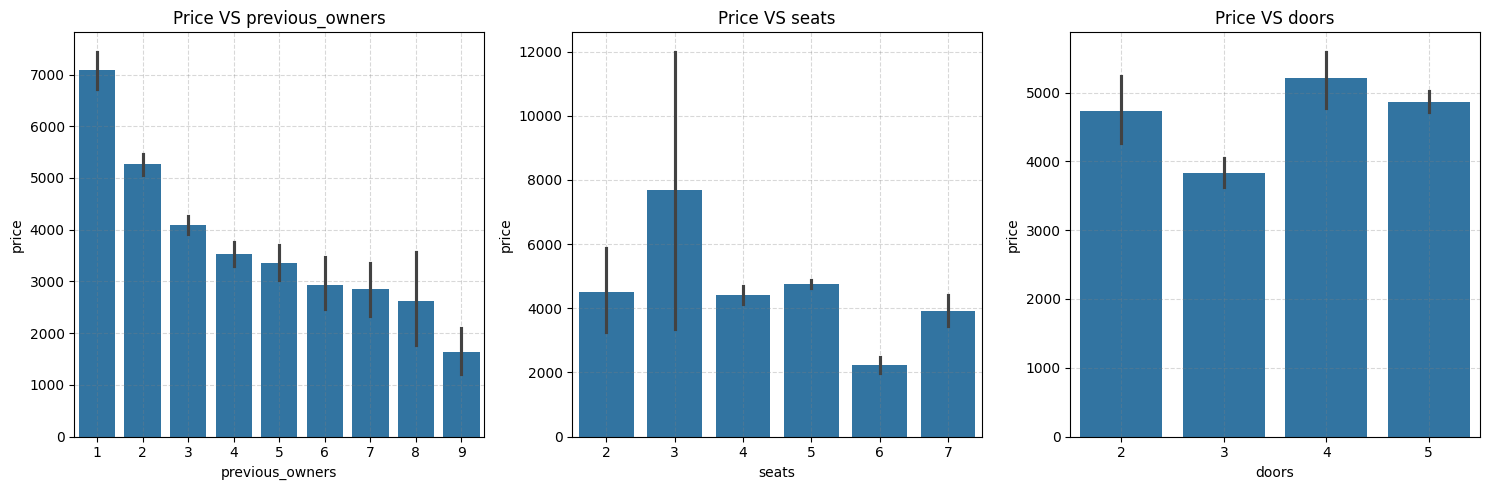

In [ ]:
features = ['previous_owners','seats','doors']

plt.figure(figsize=(15,5))
for idx, i in enumerate(features):
    plt.subplot(1,3,idx+1)
    ax=sns.barplot(data=df, x=i, y='price')
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(f'Price VS {i}')

plt.tight_layout()

**Price VS Categorical Features**

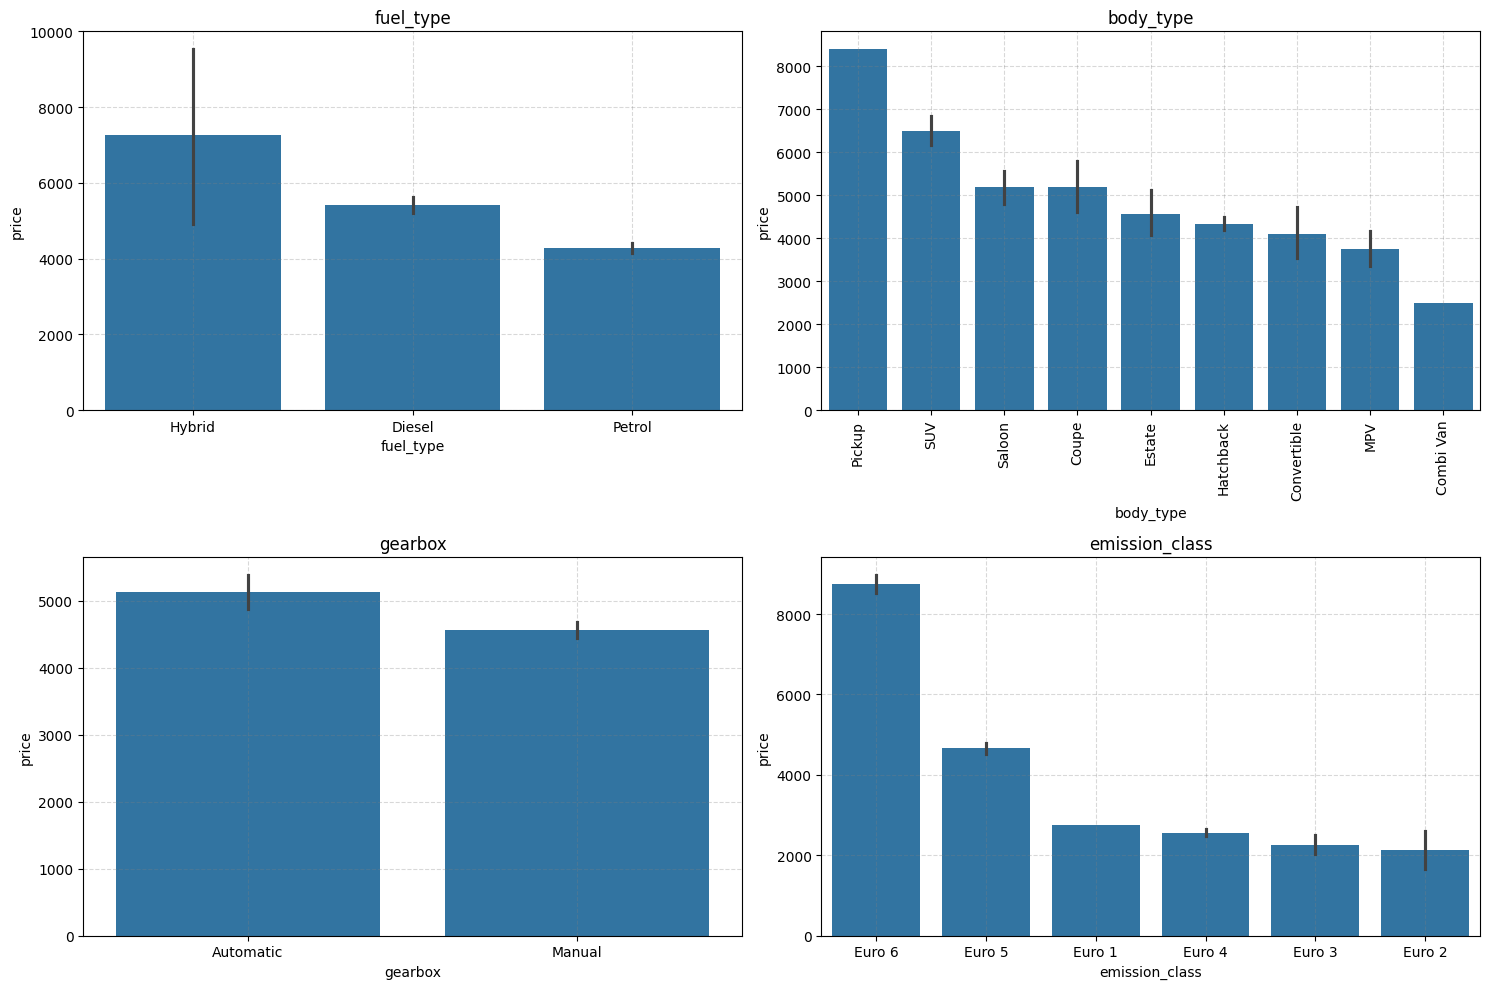

In [ ]:
features = ['fuel_type','body_type','gearbox','emission_class']
plt.figure(figsize=(15,10))
for idx,i in enumerate(features):
    urut = df.groupby(i)['price'].mean().sort_values(ascending=False).index
    plt.subplot(2,2,idx+1)
    ax=sns.barplot(x=df[i],y=df['price'],order=urut)
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(i)
    if i=='body_type':
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Reg. Year VS Emission Class**

# 4. Data Preparation

## Data Cleaning

### Outliers Handling (df_imputed)

In [ ]:
df_imputed.head()

,mileage,registration_year,previous_owners,body_type,engine,doors,seats,emission_class,fuel_type_Hybrid,fuel_type_Petrol,gearbox_Manual,price
0,70189.0,2016.0,3,1350.0,1.4,5.0,5.0,6.0,0.0,0.0,1.0,6900.0
1,88585.0,2008.0,4,1350.0,1.2,3.0,5.0,4.0,0.0,1.0,1.0,1495.0
2,137000.0,2011.0,2,1350.0,1.4,5.0,5.0,5.0,0.0,1.0,1.0,949.0
3,96731.0,2010.0,5,1350.0,1.4,3.0,4.0,4.0,0.0,1.0,1.0,2395.0
4,85000.0,2013.0,4,1350.0,1.3,5.0,5.0,5.0,0.0,0.0,1.0,1000.0


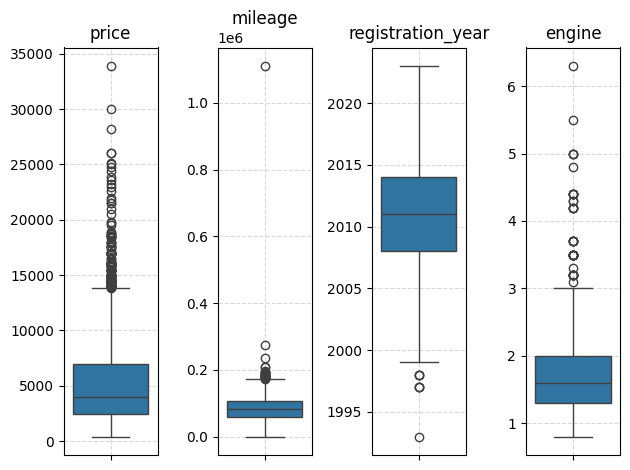

In [ ]:
kontinu = ['price','mileage','registration_year','engine']
for i in range(0,len(kontinu)):
    plt.subplot(1,4,i+1)
    sns.boxplot(y=df_imputed[kontinu[i]])
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(kontinu[i])
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
df_imputed = df_imputed.drop(df_imputed[df_imputed['registration_year'] == 1993].index)

In [ ]:
kontinu = ['price','mileage']
for i in kontinu:
    Q3 = df_imputed[i].quantile(0.75)
    Q1 = df_imputed[i].quantile(0.25)
    IQR = Q3-Q1
    bawah = Q1-1.5*IQR
    atas = Q3+1.5*IQR
    outlier = (df_imputed[i] < bawah) | (df_imputed[i] > atas)
    df_imputed = df_imputed[~outlier]

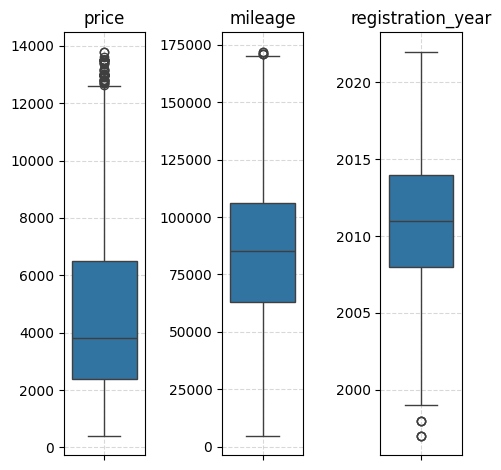

In [ ]:
kontinu = ['price','mileage','registration_year']
for i in range(0,len(kontinu)):
    plt.subplot(1,4,i+1)
    sns.boxplot(y=df_imputed[kontinu[i]])
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    plt.title(kontinu[i])
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
df_imputed.reset_index(drop=True,inplace=True)

## Data Transformation

### Encoding

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              2613 non-null   object 
 1   price              2613 non-null   float64
 2   mileage            2613 non-null   float64
 3   registration_year  2613 non-null   int64  
 4   previous_owners    2613 non-null   int64  
 5   fuel_type          2613 non-null   object 
 6   body_type          2613 non-null   object 
 7   engine             2613 non-null   float64
 8   gearbox            2613 non-null   object 
 9   doors              2613 non-null   int64  
 10  seats              2613 non-null   int64  
 11  emission_class     2613 non-null   object 
 12  brand              2613 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 265.5+ KB


In [ ]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mileage            2612 non-null   float64
 1   registration_year  2612 non-null   float64
 2   previous_owners    2612 non-null   int64  
 3   body_type          2612 non-null   float64
 4   engine             2612 non-null   float64
 5   doors              2612 non-null   float64
 6   seats              2612 non-null   float64
 7   emission_class     2612 non-null   float64
 8   fuel_type_Hybrid   2612 non-null   float64
 9   fuel_type_Petrol   2612 non-null   float64
 10  gearbox_Manual     2612 non-null   float64
 11  price              2612 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 245.0 KB


In [ ]:
df_imputed

,mileage,registration_year,previous_owners,body_type,engine,doors,seats,emission_class,fuel_type_Hybrid,fuel_type_Petrol,gearbox_Manual,price
0,70189.0,2016.0,3,1350.0,1.4,5.0,5.0,6.0,0.0,0.0,1.0,6900.0
1,88585.0,2008.0,4,1350.0,1.2,3.0,5.0,4.0,0.0,1.0,1.0,1495.0
2,137000.0,2011.0,2,1350.0,1.4,5.0,5.0,5.0,0.0,1.0,1.0,949.0
3,96731.0,2010.0,5,1350.0,1.4,3.0,4.0,4.0,0.0,1.0,1.0,2395.0
4,85000.0,2013.0,4,1350.0,1.3,5.0,5.0,5.0,0.0,0.0,1.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2607,104000.0,2009.0,3,1350.0,1.6,5.0,5.0,4.0,0.0,1.0,1.0,1695.0
2608,76202.0,2006.0,4,1350.0,1.6,5.0,5.0,4.0,0.0,1.0,1.0,1395.0
2609,119000.0,2012.0,1,249.0,2.0,4.0,5.0,5.0,0.0,1.0,1.0,6990.0
2610,139000.0,2013.0,5,249.0,2.0,4.0,5.0,5.0,0.0,0.0,1.0,3995.0


## Scaling

In [ ]:
df = df_imputed.copy()

In [14]:
#define features & target
X = df.drop(columns='price')
y = df[['price']]

#split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

NameError: name 'df' is not defined

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
models = {
    "Linear": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=1),
    "Random Forest": RandomForestRegressor(random_state=1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=1)}

#eval metrics
y_preds ={}
train_r2 = {}
test_r2 = {}
train_mae = {}
test_mae = {}
train_mse = {}
test_mse = {}

#fit_pred
for name, mdl in models.items():
    mdl.fit(X_train_scaled,y_train)
    y_pred_train = mdl.predict(X_train_scaled)
    y_pred_test = mdl.predict(X_test_scaled)
    train_r2[name] = r2_score(y_train, y_pred_train)
    test_r2[name] = r2_score(y_test, y_pred_test)
    train_mae[name] = mean_absolute_error(y_train, y_pred_train)
    test_mae[name] = mean_absolute_error(y_test, y_pred_test)
    train_mse[name] = mean_squared_error(y_train, y_pred_train)
    test_mse[name] = mean_squared_error(y_test, y_pred_test)

#evaluation
eval = pd.DataFrame({'model':list(models.keys()),
                    'R2':list(test_r2.values()),
                    })
eval